# 형태소 빈도 계수
분석 대상 자료의 속성을 드러낼 수 있는 가장 기본적인 자료 분석은 분석 단위에 대한 빈도 계수이다. 파이썬을 이용한 빈도 계수의 방법을 알아보자. 

## 형태소 분석과 빈도 계수의 결합
앞선 강의에서 살펴본 Counter 클래스를 형태소 빈도 계수에 적용해 보자. 먼저 생각해 보아야 할 것은 빈도 계수의 대상을 정하는 것이다. 형태소 빈도 계수에 있어서 아래와 같이 두 가지 빈도 계수 대상을 상정할 수 있다.

* 형태소 어휘항
* 형태소와 품사의 결합

물론 품사의 빈도를 계수하는 것도 가능하며, 이 또한 텍스트 분석에 있어서 중요한 지표가 될 수 있다. 하지만 품사의 빈도만 계수하는 것을 형태소 빈도 계수라 할 수는 없다. 위 가운데 적절하다고 판단되는 것은 형태소와 품사의 결합의 빈도를 계수하는 것이다. 동형이품사를 최대한 구분하여 빈도 계수의 정확성을 높히려는 것이다. 또한 형태소 어휘항만의 빈도 계수는 형태소와 품사의 결합에 대한 빈도 계수로부터 도출이 가능하지만 그 반대는 불가능함도 고려해야 한다.

이제 지난 강의에서 보인 형태소 분석 예제 코드를 확장하여 형태소 빈도 계수를 해보자.

In [4]:
# 형태소 빈도 계수

import re
import ujson
from collections import Counter
from konlpy.tag import Hannanum


def split_sentences(text):
    sentences = re.split("(?<=[.?!]) ", text)
    
    return sentences


def get_morph_anal(analyzer, text):
    sent_morph_anals = []
    sentences = split_sentences(text)
    
    for sentence in sentences:
        sent_morph_anal = analyzer.pos(sentence, ntags=22)
        sent_morph_anals.append(sent_morph_anal)
        
    return sent_morph_anals


def count_morphs(sent_morph_anals):
    morph_counter = Counter()
    
    for sent_morph_anal in sent_morph_anals:
        morph_counter.update(sent_morph_anal)
        
    return morph_counter


def print_morph_counts(morph_counter, top_n=None):
    for (morph_lex, morph_cat), count in morph_counter.most_common(top_n):
        print("{}\t{}\t{}".format(morph_lex, morph_cat, count))    


def main():
    my_text = """<벌레이야기>

1
아내는 알암이의 돌연스런 가출이 유괴에 의한 실종으로 확실시되고 난 다음에도 한동안은 악착스럽게 자신을 잘 견뎌 나가고 있었다. 그것은 아이가 어쩌면 행여 무사히 되돌아오게 될지도 모른다는 간절한 희망과, 녀석에게 마지막 불행한 일이 생기기 전에 어떻게든지 놈을 다시 찾아내고 말겠다는 어미로서의 강인한 의지와 기원 때문인 것 같았다.
지난해 5월 초. 어느 날 알암이가 학교에서 돌아올 시각이 훨씬 지나도록 귀가를 안 했다.
"""

    hannanum = Hannanum()
    sent_morph_anals = get_morph_anal(hannanum, my_text)
    morph_counter = count_morphs(sent_morph_anals)
    print_morph_counts(morph_counter, 20)
    
    
# 실행
main()

ㄴ	ET	6
아	EC	4
다	EF	4
.	SF	4
이	JC	3
에	JC	3
고	EC	3
게	EC	3
알암이	NC	2
나	PX	2
도	JX	2
은	JX	2
을	JC	2
었	EP	2
가	JC	2
오	PX	2
는	ET	2
하	XS	2
이	JP	2
ㄹ	ET	2


## 형태소 분석 JSON 라인 파일에 대한 형태소 빈도 계수
이제 지난 주에 생성한 JSON 라인 형식의 문서 집합 파일을 대상으로 형태소 빈도 계수를 수행해 보자. 지난 주에 작성한 코드와 위에서 작성한 코드를 결합하면 된다. 문서 집합에 대한 형태소 계수는 다음과 같이 두 가지 과제로 나뉜다.

* 문서 집합 통합 형태소 빈도 계수
* 문서별 형태소 빈도 계수

요약하면 문서 집합 전체를 하나의 문서로 간주하여 빈도를 계수할 것인가, 개별 문서의 빈도를 계수할 것인가의 선택이다. 먼저 문서 집합 전체의 통합 형태소 빈도를 계수해 보자.

In [1]:
!pip install wordcloud

In [5]:
# 문서 집합 통합 형태소 계수

import ujson
from collections import Counter

INPUT_FILE_NAME = "../data/academic/ai_bib_info.ma.txt"
OUTPUT_FILE_NAME = "../data/academic/ai_bib_info.mc.txt"
MA_KEYS = ["title_ma", "abstract_ma"]


def count_morphs():
    morph_counter = Counter()
    
    with open(INPUT_FILE_NAME, "r", encoding="utf-8") as input_file:
        for line in input_file:
            json_obj = ujson.loads(line)

            if not check_ma_keys(json_obj):
                continue

            for ma_key in MA_KEYS:
                ma = json_obj[ma_key]

                for sent_ma in ma:
                    for morph_lex, morph_cat in sent_ma:
                        morph_counter[(morph_lex, morph_cat)] += 1

    return morph_counter
    
    
def check_ma_keys(json_obj):
    for ma_key in MA_KEYS:
        if ma_key not in json_obj or not json_obj[ma_key]:
            return False
        
    return True


def write_morph_counts(morph_counter):
    with open(OUTPUT_FILE_NAME, "w", encoding="utf-8") as output_file:
        for (morph_lex, morph_cat), count in morph_counter.most_common():
            print("{}\t{}\t{}".format(morph_lex, morph_cat, count), file=output_file)      


def main():
    morph_counter = count_morphs()
    write_morph_counts(morph_counter)
    
    
# 실행
main()

위의 코드는 JSON 라인 형식의 형태소 분석 문서 집합 파일을 대상으로 통합 형태소 빈도 계수를 수행한다. 이제까지의 코드와 조금 다른 점은 입력 파일과 출력 파일을 여는 동작을 분리하여 함수 내부에서 수행한다는 것이다. 다른 부분은 이미 앞서 사용된 코드를 재활용한 것이므로 특별한 것이 없다.

이제 위의 코드를 수정하여 개별 문서별 형태소 빈도 계수를 수행하여 출력하도록 해보자.

In [6]:
# 문서 집합 개별 문서별 형태소 빈도 계수 (단일 Counter 사용)

import ujson
from collections import Counter

INPUT_FILE_NAME = "../data/academic/ai_bib_info.ma.txt"
OUTPUT_FILE_NAME = "../data/academic/ai_bib_info.dmc.txt"
MA_KEYS = ["title_ma", "abstract_ma"]


def count_morphs():
    morph_counter = Counter()
    
    with open(INPUT_FILE_NAME, "r", encoding="utf-8") as input_file:
        for doc_num, line in enumerate(input_file, 1):
            json_obj = ujson.loads(line)

            if not check_ma_keys(json_obj):
                continue

            for ma_key in MA_KEYS:
                ma = json_obj[ma_key]

                for sent_ma in ma:
                    for morph_lex, morph_cat in sent_ma:
                        morph_counter[(doc_num, morph_lex, morph_cat)] += 1

    return morph_counter
    
    
def check_ma_keys(json_obj):
    for ma_key in MA_KEYS:
        if ma_key not in json_obj or not json_obj[ma_key]:
            return False
        
    return True


def write_morph_counts(morph_counter):
    with open(OUTPUT_FILE_NAME, "w", encoding="utf-8") as output_file:
        for (doc_num, morph_lex, morph_cat), count in morph_counter.most_common():
            print("{:04d}\t{}\t{}\t{}".format(doc_num, morph_lex, morph_cat, count), file=output_file)      


def main():
    morph_counter = count_morphs()
    write_morph_counts(morph_counter)
    
    
# 실행
main()

바뀐 것은 형태소 빈도 계수의 키로 문서 번호를 추가한 것뿐이다. 문서 번호는 `for ... in ...` 문으로 텍스트 파일에서 줄 단위로 문서를 읽을 때에 `enumerate()` 함수를 적용하여 얻는다. 그리고 핵심적인 것은 아니지만 문서 번호를 출력할 때에 포맷팅을 적용하여 이른바 left zero padding을 수행하였다.

>문자열 포맷팅은 다소 복잡하지만 많이 사용되는 것 몇 가지만 알면 된다. <https://docs.python.org/3.5/tutorial/inputoutput.html#fancier-output-formatting>와 <https://docs.python.org/3.5/library/string.html#formatstrings> 참조.

한편 위와 같은 일을 하는 코드를 다음과 같이 작성할 수도 있다.

In [7]:
# 문서 집합 개별 문서별 형태소 빈도 계수 (개별 Counter 사용)

import ujson
from collections import Counter

INPUT_FILE_NAME = "../data/academic/ai_bib_info.ma.txt"
OUTPUT_FILE_NAME = "../data/academic/ai_bib_info.dmc.2.txt"
MA_KEYS = ["title_ma", "abstract_ma"]


def count_morphs():
    morph_counters = {}
    
    with open(INPUT_FILE_NAME, "r", encoding="utf-8") as input_file:
        for doc_num, line in enumerate(input_file, 1):
            json_obj = ujson.loads(line)

            if not check_ma_keys(json_obj):
                continue
                
            morph_counter = Counter()

            for ma_key in MA_KEYS:
                ma = json_obj[ma_key]

                for sent_ma in ma:
                    for morph_lex, morph_cat in sent_ma:
                        morph_counter[(morph_lex, morph_cat)] += 1
                        
            morph_counters[doc_num] = morph_counter

    return morph_counters
    
    
def check_ma_keys(json_obj):
    for ma_key in MA_KEYS:
        if ma_key not in json_obj or not json_obj[ma_key]:
            return False
        
    return True


def write_morph_counts(morph_counters):
    with open(OUTPUT_FILE_NAME, "w", encoding="utf-8") as output_file:
        for doc_num, morph_counter in sorted(morph_counters.items()):
            for (morph_lex, morph_cat), count in morph_counter.most_common():
                print("{:04d}\t{}\t{}\t{}".format(doc_num, morph_lex, morph_cat, count), file=output_file)      


def main():
    morph_counters = count_morphs()
    write_morph_counts(morph_counters)
    
    
# 실행
main()

위의 코드는 하나의 Counter 객체가 아니라 개별 문서별로 Counter 객체를 사용한다는 점에서 차이가 있다. 복수의 Counter 객체는 딕셔너리에 저장한다. 이 때 앞선 코드와 같은 방법으로 얻은 문서 번호를 키로 하고 값은 Counter 객체로 한다. 출력부에서는 `sorted()` 함수를 이용하여 문서 번호로 정렬된 결과를 얻을 수 있도록 하였다.

## 형태소 빈도의 시각화
"보기 좋은 떡이 먹기 좋다"는 말이 있지 않던가. 같은 정보라도 시각화를 어떻게 하느냐에 따라 효용이 다르다. 이 강좌에서는 본격적인 정보 시각화는 다루지 않지만 몇몇 대표적인 텍스트 처리 관련 시각화를 소개한다.

## 지프 곡선 그리기
어휘 빈도의 분포에 관한 고전적인 연구 결과 가운데 하나는 어휘 빈도의 분포가 이른바 지프의 법칙(Zipf's Law)을 따른다는 것이다. 이 법칙에 따르면 어휘 빈도수와 해당 빈도수를 가지는 어휘의 빈도 순위 사이에는 일정한 수리적 관계가 존재한다. 이 관계는 빈도수와 빈도 순위, 각각에 대하여 로그를 취하여 챠트를 그렸을 때에 음의 기울기를 가지는 직선에 근접하는 선이 그려지는 것으로 확인할 수 있다.

다음 스크립트는 앞서 작성한 형태소 빈도 계수 스크립트에 의해 생성된 TSV 형식의 빈도 계수 파일의 내용을 읽어서 지프 곡선을 그리는 스크립트이다.

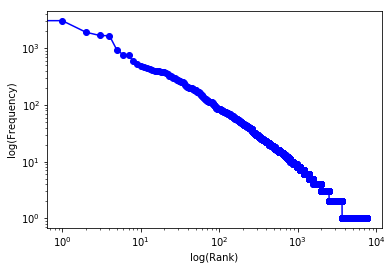

In [8]:
# 지프 곡선 그리기

from collections import Counter
import matplotlib.pyplot as plt

INPUT_FILE_NAME = "../data/academic/ai_bib_info.mc.txt"


def read_morph_counts():
    morph_counts = Counter()
    
    with open(INPUT_FILE_NAME, "r", encoding="utf-8") as input_file:
        for line in input_file:
            morph_lex, morph_cat, count = line.strip().split("\t")
            morph_counts[(morph_lex, morph_cat)] = int(count)
            
    return morph_counts


def plot_zip_curve(morph_counts):
    """
    빈도수 분포의 지프 곡선을 그린다.
    """

    count_vals = list(morph_counts.values())
    count_vals = sorted(count_vals, reverse=True)
    plt.plot(count_vals, color="blue", marker="o")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("log(Rank)")
    plt.ylabel("log(Frequency)")
    plt.show()

    
def main():
    """
    형태소 빈도 파일을 읽어서 빈도수 분포의 개형을 보이는 지프 곡선을 그린다.
    """

    morph_counts = read_morph_counts()
    plot_zip_curve(morph_counts)


# 실행
main()

위에서 정의한 `read_morph_counts()` 함수는 TSV 형식의 빈도 계수 파일을 읽어서 Counter 객체를 만들어 돌려준다. 지금의 경우에는 굳이 Counter 클래스를 사용하지 않고 딕셔너리를 사용해도 된다.

이 스크립트의 핵심은 matplotlib 라이브러리를 이용하는 `plot_zip_curve()` 함수이다. matplotlib 라이브러리는 파이썬을 이용한 데이터 시각화의 표준 라이브러리로 받아들여질 만큼 널리 쓰이는 라이브러리이다. 이 강좌에서는 이 라이브러리에 대하여 깊이 다루지는 않는다.

`plot_zip_curve()`에서는 matplotlib.pyplot 모듈에서 제공하는 `plot()` 함수를 이용하여 챠트의 입력 자료, 색상, 마커의 모양을 설정한 다음, `xscale()/yscale()` 함수로 스케일링을 설정한 후, `xlabel()/ylabel()` 함수로 X축과 Y축에 제목을 붙인다. 마지막으로 `show()` 함수를 호출하여 준비된 챠트를 화면에 표시한다. 여기서 스케일링을 하지 않으면 로그 스케일링 이전의 원래 곡선의 모습을 볼 수 있다. 빈도를 `values()` 메소드로 추출하고 빈도 역순 추출을 위해 `sorted()` 함수를 `reverse` 인자를 적용하여 사용한다.

## 워드 클라우드 그리기
어휘 빈도를 시각화하는 방법 가장 널리 알려진 워드 클라우드를 그려보자. 
우리가 사용할 라이브러리는 wordcloud(<https://pypi.python.org/pypi/wordcloud>)이다. 
이 라이브러리는 C 언어로 작성된 확장 모듈을 포함하고 있는데 저장소에서 바이너리 패키지를 제공하지 않기 때문에 비공식 파이썬 패키지 배포 사이트(<http://www.lfd.uci.edu/~gohlke/pythonlibs>)에서 파이썬 인터프리터의 버전과 컴퓨터의 아키텍처에 맞는 패키지를 내려받아 설치해야 한다. 
대부분의 사용자는 다음과 같이 64 비트용 패키지를 설치하면 될 것이다.

```
> pip install wordcloud-1.2.1-cp35-cp35m-win_amd64.whl
```

>맥오에스나 리눅스 사용자는 `pip`으로 소스 패키지를 컴파일하여 설치한다. `pip install wordcloud`

워드 클라우드 그리기의 소스는 다음과 같다.

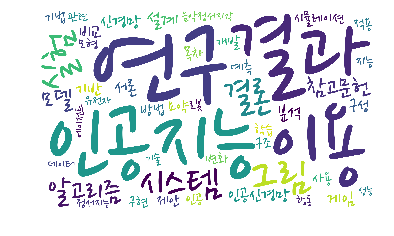

In [27]:
import sys
import matplotlib.pyplot as plt
import wordcloud

INPUT_FILE_NAME = "../data/academic/ai_bib_info.mc.txt"
FILTER_IN_POSES = ["NC", "NQ"]
NUM_MORPHS = 200
BACKGROUND_COLOR = "white"
WIDTH = 2500
HEIGHT = 1500


def read_morph_counts():
    morph_counts = Counter()
    
    with open(INPUT_FILE_NAME, "r", encoding="utf-8") as input_file:
        for line in input_file:
            morph_lex, morph_cat, count = line.strip().split("\t")
            
            if morph_cat not in FILTER_IN_POSES:
                continue
            
            morph_counts[(morph_lex, morph_cat)] = int(count)
            
            if len(morph_counts) >= NUM_MORPHS:
                break
            
    return morph_counts


def generate_text(morph_counts):
    text_morphs = []

    for (morph_lex, morph_cat), count in morph_counts.most_common():
        # 어휘 빈도를 작은 수로 조정한다.
        count = int(round(count / 100))
        sub_text_morphs = [morph_lex] * count
        text_morphs.extend(sub_text_morphs)
        # 위는 아래와 같은 표현이다.
        # text_morphs += sub_text_morphs

    text = " ".join(text_morphs)

    return text


def draw_cloud(text):
    if sys.platform == "win32" or sys.platform == "win64":
        font_path = "C:/Windows/Fonts/nanumPen.ttf"
    elif sys.platform == "darwin":
        font_path = "/Library/Fonts/AppleGothic.ttf"

    cloud_gen = wordcloud.WordCloud(background_color=BACKGROUND_COLOR,
                                    width=WIDTH, height=HEIGHT,
                                    font_path=font_path)
    cloud = cloud_gen.generate(text)

    return cloud


def show_cloud(cloud):
    plt.imshow(cloud)
    plt.axis("off")
    plt.show()

    
def main():
    morph_counts = read_morph_counts()
    text = generate_text(morph_counts)
    cloud = draw_cloud(text)
    show_cloud(cloud)


# 실행
main()

위 스크립트도 앞서와 마찬가지로 `read_morph_counts()` 함수를 정의하여 사용한다. 그런데 이번에는 읽어들일 형태소의 품사와 개수를 지정할 수 있도록 하였다. 제한된 지면을 활용하는 워드 클라우드 특성상 읽어들일 형태소의 수를 상위 200위까지로 한정하였고, 품사도 개념어인 일반명사와 고유명사로 제한했다.

중요한 부분은 워드 클라우드를 생성하고 화면에 표시하는 부분이다.  이는 라이브러리의 웹사이트(<http://amueller.github.io/word_cloud>)에 있는 설명과 예제에서 거의 그대로 따온 것이다. 

wordcloud 모듈에서 클라우드를 생성하는 `generate()` 메소드는 인자로 문자열을 받는다. 이 문자열은 다름아닌 입력 텍스트이다.  우리가 이용하는 자료는 형태소 빈도 계수 결과이므로 개별 형태소가 해당 빈도만큼 반복된 텍스트를 생성해야 한다. 이 때 빈도수를 큰 숫자보다는 적절히 조정해야 워드 클라우드가 보기 좋게 생성된다. 여기서는 간단히 어휘 빈도를 10으로 나눈 후 반올림(`round()`)한 다음 정수로 변환(`int()`)하여 사용한다.   이는 경험적으로 정한 것일 뿐이며 꼭 이렇게 해야 하는 것은 아니다. 

>워드 클라우드에서는 빈도뿐만 아니라 어휘들의 중요도를 나타낼 수 있는 수치이면 어느 수치나 사용 가능하다.

# 키워드 추출
키워드는 우리말로 핵심어라고도 부르는데, 한국정보통신기술협회에서 제공하는 정보통신용어사전(<http://terms.tta.or.kr>)에서는 "설명문의 내용을 서술하는 설명 또는 제목 내의 중요한 내용을 요약한 핵심적인 단어 또는 문구. 단어/문서를 검색할 때 핵심어를 이용하면 원하는 정보를 쉽게 찾을 수 있다."라고 정의한다.

## 불용어의 제거
키워드의 정의에서 주목할 부분은 **중요한 내용을 요약한 핵심적인 단어 또는 문구**로 키워드의 기능과 형태를 설명하고 있다. 이에 따르면 한국어에서 조사와 어미, 그리고 접사류는 키워드로 보기 힘들다. 이들은 언어학적으로 문법 형태소로 분류되는 것들로 어휘 의미를 표현하기보다는 문법적인 의미를 나타내는 범주들이다. 또한 이들은 단어보다 작은 언어 단위이다. 그러면 다른 형태소들, 즉, 명사류와 동사, 형용사, 그리고 관형사, 부사는 어떨까? 이들은 어휘 형태소로서 대체로 어휘적인 의미를 나타낸다. 그러나 명사류에서도 수사와 대명사는 그렇게 보기 어렵다. 경우에 따라서는 수식어로 사용되는 관형사와 부사, 나아가 서술어로 사용되는 동사와 형용사도 키워드로 보기 어려울 수도 있다. 이와 같이 분석 대상 문서의 내용을 요약적으로 표현하기 어려운 어휘들을 **불용어**(stopwords)라고 부른다. 한국어 텍스트 처리에서는 조사와 어미, 접사류, 문장 부호, 대명사, 수사 등은 대체로 불용어로 간주되며 그 외의 어휘들도 경우에 따라 불용어로 처리되기도 한다.

>작가들의 고유한 특성을 밝히는 문체 분석에서는 오히려 조사와 어미 등이 중요한 역할을 하는 것으로 알려져 있다.

## 단순 어휘 빈도에 근거한 키워드 추출
키워드를 특정 문헌의 내용을 요약적으로 표현하는 형태소의 집합이라고 정의할 때에 가장 먼저 시도할 수 있는 키워드 추출 방법은 형태소 빈도에 의한 방법이다.
즉, 특정 문헌에서 많이 나타나는 형태소가 그 문헌의 내용을 나타낼 가능성이 높다는 가정을 하는 것이다.

다음 스크립트는 문헌별 단순 어휘 빈도에 근거한 문헌별 키워드 추출을 수행한다.

>문헌별 단순 어휘 빈도를 문헌 정보학에서는 용어로 용어 빈도(term frequency)라 부른다.

In [8]:
# 용어 빈도에 의한 키워드 추출

import ujson
from collections import Counter

INPUT_FILE_NAME = "../data/academic/ai_bib_info.ma.txt"
OUTPUT_FILE_NAME = "../data/academic/ai_bib_info.kw.tf.txt"
FILTER_IN_POSES = ["NC", "NQ"]
MA_KEYS = ["title_ma", "abstract_ma"]
TOP_N = 10


def read_documents(input_file):
    docs = []

    for line in input_file:
        json_obj = ujson.loads(line)

        if not check_ma_keys(json_obj):
            continue

        morphs = []

        for ma_key in MA_KEYS:
            for sent_ma in json_obj[ma_key]:
                for morph_lex, morph_cat in sent_ma:
                    if morph_cat not in FILTER_IN_POSES:
                        continue

                    morphs.append(morph_lex)

        ma_doc = {
            "title": json_obj["title"],
            "abstract": json_obj["abstract"],
            "morphs": morphs
        }
        docs.append(ma_doc)

    return docs


def check_ma_keys(json_obj):
    for ma_key in MA_KEYS:
        if ma_key not in json_obj or not json_obj[ma_key]:
            return False
        
    return True


def get_term_freq_counters(docs):
    term_freq_counters = []

    for doc in docs:
        term_freq_counter = Counter()
        term_freq_counter.update(doc["morphs"])
        term_freq_counters.append(term_freq_counter)

    return term_freq_counters


def extract_tf_keywords(term_freq_counters):
    tf_keywords = []

    for term_freq_counter in term_freq_counters:
        keywords = []
        
        for term, term_freq in term_freq_counter.most_common(TOP_N):
            keywords.append(term)
            
        tf_keywords.append(keywords)

    return tf_keywords


def write_keywords(output_file, docs, tf_keywords):
    for doc, keywords in zip(docs, tf_keywords):
        print("제목: {}".format(doc["title"]), file=output_file)
        print("요약문: {}".format(doc["abstract"]), file=output_file)
        print("키워드: {}".format(", ".join(keywords)), file=output_file)
        print("=" * 60, file=output_file)

        
def main():
    with open(INPUT_FILE_NAME, "r", encoding="utf-8") as input_file, \
            open(OUTPUT_FILE_NAME, "w", encoding="utf-8") as output_file:
        docs = read_documents(input_file)
        term_freq_counters = get_term_freq_counters(docs)
        tf_keywords = extract_tf_keywords(term_freq_counters)
        write_keywords(output_file, docs, tf_keywords)


# 실행
main()

위 스크립트는 앞서 이용한 인공지능 관련 논문 집합에서 초록이 존재하는 경우만 골라서 논문 제목과 초록의 형태소 분석 결과로부터 일반명사(NNG), 고유명사(NNP), 어근(XR) 형태소를 추출한 뒤 이들의 용어 빈도를 측정한 다음 상위 10개만 키워드로 추출한다. 대부분의 코드가 앞서 사용한 코드를 재활용하여 구성한 것이다. 

`read_documents()` 함수에서 딕셔너리를 이용하여 입력 문서를 가공하여 돌려주며, `get_term_freq_counters()` 함수에서 입력 문서들을 대상으로 Counter 객체들을 생성한다. `extract_tf_keywords()` 함수는 앞에서 생성한 Counter 객체들로부터 `TOP_N`으로 정의된 수만큼의 키워들을 추출한다 마지막으로 `write_keywords()` 함수는 입력 문서 집합과 키워드 추출 결과를 `zip()` 함수로 결합하여 출력 파일에 기록한다.

위 스크립트를 실행하여 생성된 출력 파일(`ai_bib_info.kw.tf.txt`)의 내용을 일부 보이면 다음과 같다.

```
...
제목: 일본의 미래시대를 지배할 ‘인공지능(AI)’ 연구 및 정책 동향
요약문: 글로벌 미래연구 싱크탱크라고 불리는 ‘밀레니엄 프로젝트(The Millennium Project) 내 전문가들이 
다양한 기법을 활용해 미래를 예측한 보고서인 유엔미래보고서(State of Future)에서 2045년에는 인공지능이 
인간을 초월할 것으로 예측한 바 있다. 세계적인 미래학자인 레이 커즈와일(Raymond Kurzweil) 박사도 
“세상을 모델로 인간이 만들어낸 인공지능이 인간 지능을 앞서는 특이점(Singularity)을 돌파하게 되면 
인공지능 스스로 가속적인 추론을 거듭하여 수퍼 지능(Super Intelligence)의 상태에 도달하게 될 것”이라고 
예견하였으며, 구글 최고경영자(CEO)인 래리 페이지도 “인공지능이 인간에게 혜택을 가져올 것”이라는 
긍정적인 전망을 내놓았다. 한편, 영국의 우주 물리학자 스티븐 호킹 박사는 “생각>하는 로봇 개발을 위한 
완전한 인공지능의 등장은 인류의 멸망을 가져올 것”이라며 인공지능 기술 발전이 인류 생존에 중대한 위협이 
될 수 있다고 경고하면서 인간 능력에 필적하거나 뛰어넘을 수 있는 인>공지능을 경계하는 부정적 입장도 
존재하고 있다.
키워드: 인공지능, 인간, 미래, 인류, 예측, 박사, 지능, 연구, 보고서, 생각
...
```

## 용어 빈도 역문헌 빈도에 근거한 키워드 추출
위에서 보인 용어 빈도에 근거한 키워드 추출 결과는 제법 유용하다. 
하지만 어떤 키워드들은 해당 논문의 내용을 나타낸다고 할 수는 있지만 너무 흔하게 쓰이는 용어여서 해당 논문만의 특징적인 내용을 나타내기에는 부적합할 수도 있다. 
즉, 용어 빈도에 근거해 추출한 키워드들 가운데에는 특정성(specificity)이 부족한 것들이 있다.
특정성이 높은 용어들의 특징은 상대적으로 드물게 쓰인다는 것이다.
다른 말로 하면, 넓게 쓰이지 않는다고 할 수 있으며, 결국 어떤 용어가 하나의 문헌에서도 많이 사용되고 그 문헌이 속한 전체 문헌 집합에 속한 다수의 다른 문헌들에서 널리 쓰였다면 이 용어는 특정성이 떨어지는 용어이다.
이 때 특정 용어가 사용된 문헌의 수를 문헌 빈도(DF: document frequency)라고 부르며, 이의 역에 해당하는 역문헌 빈도(IDF: inverse document frequency)도 정의할 수 있다. 
수식으로는 다음과 같이 표현할 수 있다.

$$
    \operatorname{idf}(t, D) = \log\frac{|D|}{|\{d \in D: t \in d\}|}
$$

* $|D|$: 전체 문헌 집합 $D$의 크기, 곧 전체 문헌의 수
* $|\{d \in D: t \in d\}|$: 용어 $t$가 포함된 문헌의 수

위의 수식의 의미는 주어진 용어 $t$와 전체 문헌 집합 $D$에 대한 역문헌 빈도는 전체 문헌의 수를 주어진 용어가 출현한 문헌들의 수, 즉 문헌 빈도로 나눈 값에 로그를 취한 값으로 정의한다는 것이다.
주어진 용어 $t$가 출현한 문서의 수가 많으면 많을수록 역문헌 빈도의 값이 작아지며, 그러한 문서의 수가 적으면 적을수록 역문헌 빈도의 값이 커진다.
즉, 특정성이 커진다.
나누기 연산을 통해 얻어진 값에 로그를 취하여 스케일링을 하면 값이 평탄화가 이루어진다.
한편, 어떤 용어의 문헌 빈도가 0일 경우에 대해서도 역문헌 빈도를 정의해야 할 수 있기 때문에 실제로는 다음과 같이 최소 문헌 빈도를 1로 설정한 값이 많이 사용된다.

$$
    \operatorname{idf}(t, D) = \log\frac{|D|}{|\{d \in D: t \in d\}|+1}
$$

실제 자료 처리에 있어서는 용어 빈도도 다음과 같이 평탄화하여 사용한다.

$$
    \operatorname{tf}(t, d) = \log(\operatorname{tf}(t, d)+1)
$$

TFIDF를 구하는 위의 과정을 앞서 용어 빈도에 근거한 키워드 추출 스크립트에 추가하여 구현한 스크립트의 소스는 다음과 같다.

In [9]:
# 용어 빈도 역문헌 빈도에 의한 키워드 추출

import ujson
import math
from collections import Counter

INPUT_FILE_NAME = "../data/academic/ai_bib_info.ma.txt"
OUTPUT_FILE_NAME = "../data/academic/ai_bib_info.kw.tfidf.txt"
FILTER_IN_POSES = ["NC", "NQ"]
MA_KEYS = ["title_ma", "abstract_ma"]
TOP_N = 10


def read_documents(input_file):
    docs = []

    for line in input_file:
        json_obj = ujson.loads(line)

        if not check_ma_keys(json_obj):
            continue

        morphs = []

        for ma_key in MA_KEYS:
            for sent_ma in json_obj[ma_key]:
                for morph_lex, morph_cat in sent_ma:
                    if morph_cat not in FILTER_IN_POSES:
                        continue

                    morphs.append(morph_lex)

        ma_doc = {
            "title": json_obj["title"],
            "abstract": json_obj["abstract"],
            "morphs": morphs
        }
        docs.append(ma_doc)

    return docs


def check_ma_keys(json_obj):
    for ma_key in MA_KEYS:
        if ma_key not in json_obj or not json_obj[ma_key]:
            return False
        
    return True


def get_term_freq_counters(docs):
    term_freq_counters = []

    for doc in docs:
        term_freq_counter = Counter()
        term_freq_counter.update(doc["morphs"])
        term_freq_counters.append(term_freq_counter)

    return term_freq_counters


def get_doc_freq_counter(docs):
    doc_freq_counter = Counter()

    for doc in docs:
        doc_freq_counter.update(set(doc["morphs"]))

    return doc_freq_counter


def extract_tf_keywords(term_freq_counters):
    tf_keywords = []

    for term_freq_counter in term_freq_counters:
        keywords = []
        
        for term, term_freq in term_freq_counter.most_common(TOP_N):
            keywords.append(term)
            
        tf_keywords.append(keywords)

    return tf_keywords


def get_tfidf_counters(term_freq_counters, doc_freq_counter):

    tfidf_counters = []
    num_docs = len(term_freq_counters)

    for term_freq_counter in term_freq_counters:
        tfidf_counter = Counter()

        for term, term_freq in term_freq_counter.items():
            tf = math.log(term_freq + 1)
            df = doc_freq_counter[term] + 1
            idf = math.log(num_docs / df)
            tfidf = tf * idf
            tfidf_counter[term] = tfidf

        tfidf_counters.append(tfidf_counter)

    return tfidf_counters


def extract_tfidf_keywords(tfidf_counters):
    tfidf_keywords = []

    for tfidf_counter in tfidf_counters:
        keywords = []

        for term, tfidf in tfidf_counter.most_common(10):
            keywords.append(term)

        tfidf_keywords.append(keywords)

    return tfidf_keywords


def write_keywords(output_file, docs, tf_keywords, tfidf_keywords):
    """
    문헌별 키워드를 출력 파일에 기록한다.
    """

    for doc, tf_keywords, tfidf_keywords in zip(docs, tf_keywords,
                                                tfidf_keywords):
        print("제목: {}".format(doc["title"]), file=output_file)
        print("초록: {}".format(doc["abstract"]), file=output_file)
        print("TF키워드: {}".format(", ".join(tf_keywords)), file=output_file)
        print("TFIDF키워드: {}".format(", ".join(tfidf_keywords)),
              file=output_file)
        print("=" * 60, file=output_file)


def main():
    with open(INPUT_FILE_NAME, "r", encoding="utf-8") as input_file, \
            open(OUTPUT_FILE_NAME, "w", encoding="utf-8") as output_file:
        docs = read_documents(input_file)
        term_freq_counters = get_term_freq_counters(docs)
        tf_keywords = extract_tf_keywords(term_freq_counters)
        doc_freq_counter = get_doc_freq_counter(docs)
        tfidf_counters = get_tfidf_counters(term_freq_counters, doc_freq_counter)
        tfidf_keywords = extract_tfidf_keywords(tfidf_counters)
        write_keywords(output_file, docs, tf_keywords, tfidf_keywords)
        
        
# 실행
main()

위의 스크립트는 세부 코드는 다소 복잡해 보이지만 위의 수식을 코드로 옮긴 것이다.
다만 위의 코드는 최적화되어 있지는 않다. 
TIIDF에 근거하여 추출한 키워드를 추가한 예제 문서는 다음과 같다.

```
제목: 일본의 미래시대를 지배할 ‘인공지능(AI)’ 연구 및 정책 동향
...
TF키워드: 인간, 미래, 예측, 인류, 지능, 보고서, 박사, 연구, 생존, 예견
TFIDF키워드: 인류, 박사, 미래, 인간, 보고서, 예견, 프로젝트, 싱크탱크, 미래학자, 밀레니엄
```

# 차별어 추출
앞서 추출한 키워드는 다수의 문헌이 포함된 문헌 집합 내에서 특정 문헌을 향한 특정성, 즉 역문헌 빈도를 이용하여 용어 빈도를 조정함으로 하여 추출된 것이다.
그런데 관심이 두 개 이상의 문헌, 혹은 문헌 집합의 비교에 있다면 접근 방법을 조금 달리 해야 한다.
이 경우에는 보통 통계학에서 복수의 집단 간의 속성의 비교에 널리 사용되는 가설 검증에 기반한 방법들을 사용하는 경우가 많다. 
이 강좌에서는 정보이론적으로 집단 간 비교에 쓰이는 쿨백-라이블러 발산(Kullback-Leibler divergence)을 이용하여 두 문헌 집합을 비교하여 각각의 특징을 보이는 차별어를 추출해 본다.

## 쿨백-라이블러 발산 
KL 발산은 확률 분도 간의 차이를 측정하는 방법으로 두 확률 분포 $P$와 $Q$의 KL 발산은 다음과 같이 정의된다.

$$
    D_{KL}(P||Q) = \sum_i P(i)\log\frac{P(i)}{Q(i)}
$$

그런데 우리는 확률 분포 자체의 차이를 측정하는 것이 아니라 개별 변수의 확률값의 차이를 측정하려 하므로 점대점 KL 발산(pointwise KL divergence)을 다음과 같이 정의한다.

$$
    D_A(q_A||r)=q_A(W)\cdot\log\frac{q_A(W)}{r(W)}
$$

위에서 $q_a(W)$는 어휘 $W$가 문헌 집합 $A$에 출현하는 확률이며, $r(W)$는 어휘 $W$가 문헌 집합 $A$에 출현하는 확률과 비교 대상 문헌 집합에서 출현하는 확률의 평균이다. 어떤 어휘가 어떤 문헌 집합에 출현하는 확률은 상대 빈도로 계산할 수 있다.  즉, 해당 어휘의 빈도를 해당 문서 집합에 출현하는 모든 어휘의 수로 나누어 구하는 것이다.

예를 들어 보자. 우리에게 두 개의 문헌 집합 A와 B가 있고 "자유"라는 어휘가 각각의 문헌 집합에서 상대적으로 얼마나 중요한지, 혹은 기여를 하고 있는지를 비교하고자 한다. 이 때 어휘 "자유"가 문헌 집합 A와 B에서 각각 200회, 400회 발현하였고, 두 문서 집합의 총 어휘수는 각각 5000, 7000이라고 하자.
즉, "자유"의 문헌 집합 A에서의 발현 확률은 $\frac{200}{5000}=0.04$이고 문헌 집합 B에서의 발현 확률은 $\frac{400}{7000}=0.057$이다.
그러면 어휘 "자유"의 문헌 집합 A에서의 중요도는 다음과 같이 구할 수 있다.

$$
    0.057 \times \log\frac{0.057}{\frac{0.04+0.057}{2}} = 0.1406
$$

어휘 "자유"는 문헌 집합 B에서의 중요도가 크다고 측정된다.
다른 말로 하면 어휘 "자유"는 문헌 집합 B의 **차별어**라고 볼 수 있다.

위의 과정을 잘 살펴보면 KL 발산을 구하는 것은 어떤 어휘의 발현 확률을 다른 문서 집합에서의 발현 확률과 비교한 값으로 조정하는 절차임을 알 수 있다.
그 점에서 앞서 살펴본 TFIDF의 논리와 상당 부분 맞닿아 있다.

## 차별어 추출을 통한 문헌 집합의 비교
KL 발산에 의한 차별어 추출 방법을 실제 자료에 적용해 보자.
실험해 사용할 자료는 역대 대통령들의 연설문 자료이다.
이명박, 노무현 두 대통령의 연설문의 차별어를 추출한다.

먼저 KL 발산을 계산하여 차별어를 추출하는 스크립트의 소스를 보자.

In [28]:
# 차별어 추출

import sys
import ujson
import math
from collections import Counter

FILTER_IN_POSES = ["NC", "NQ", "PV", "PA", "MA"]
MA_KEY = "body_ma"
INPUT_FILE_NAME = "../data/speeches/speeches.ma.txt"
OUTPUT_FILE_NAME = "../data/speeches/speeches.kl.txt"


def get_morph_counters(input_file):
    mh_morph_counter = Counter()
    mb_morph_counter = Counter()

    for line in input_file:
        json_obj = ujson.loads(line.strip())

        if json_obj["president"] not in ["노무현", "이명박"]:
            continue

        for sent_ma in json_obj[MA_KEY]:
            for morph_lex, morph_cat in sent_ma:
                if morph_cat not in FILTER_IN_POSES:
                    continue

                if json_obj["president"] == "노무현":
                    mh_morph_counter[morph_lex] += 1
                else:
                    mb_morph_counter[morph_lex] += 1

    return mh_morph_counter, mb_morph_counter


def get_morph_probs(morph_counter):
    morph_probs = Counter()
    sum_morph_freqs = sum(morph_counter.values())

    for morph, freq in morph_counter.items():
        morph_probs[morph] = freq / sum_morph_freqs

    return morph_probs


def get_kl_divs(morph_probs_a, morph_probs_b):
    kl_divs_a = Counter()
    kl_divs_b = Counter()
    all_morphs = set(morph_probs_a.keys()) | set(morph_probs_b.keys())

    for morph in all_morphs:
        morph_prob_a = morph_probs_a[morph]
        morph_prob_b = morph_probs_b[morph]
        avg_morph_prob = (morph_prob_a + morph_prob_b) / 2

        # 형태소 발현 확률이 0이면 KL 발산을 음의 무한대로 정의한다.

        if morph_prob_a == 0.0:
            kl_divs_a[morph] = -math.inf
        else:
            kl_divs_a[morph] = morph_prob_a * math.log(morph_prob_a /
                                                       avg_morph_prob)

        if morph_prob_b == 0.0:
            kl_divs_b[morph] = -math.inf
        else:
            kl_divs_b[morph] = morph_prob_b * math.log(morph_prob_b /
                                                       avg_morph_prob)

    return kl_divs_a, kl_divs_b


def write_kl_divs(output_file, kl_divs_a, kl_divs_b):
    print("MH 연설문 차별어\t\tMB 연셜문 차별어", file=output_file)

    for (morph_a, kl_div_a), (morph_b, kl_div_b) \
            in zip(kl_divs_a.most_common(50), kl_divs_b.most_common(50)):
        print("{}\t{}\t{}\t{}".format(morph_a, kl_div_a, morph_b, kl_div_b),
              file=output_file)

        
def main():
    with open(INPUT_FILE_NAME, "r", encoding="utf-8") as input_file, \
            open(OUTPUT_FILE_NAME, "w", encoding="utf-8") as output_file:
        mh_morph_counter, mb_morph_counter = get_morph_counters(input_file)
        mh_morph_probs = get_morph_probs(mh_morph_counter)
        mb_morph_probs = get_morph_probs(mb_morph_counter)
        mh_kl_divs, mb_kl_divs = get_kl_divs(mh_morph_probs, mb_morph_probs)
        write_kl_divs(output_file, mh_kl_divs, mb_kl_divs)


# 실행
main()

KL 발산을 측정하려는 형태소의 발현 확률이 0일 때에 KL 발산을 음의 무한대로 설정하는 것 이외에는 위에서 보인 공식을 그대로 파이썬으로 옮긴 것이라 특별한 것이 없다.
Counter 객체의 `values()`, `keys()`, `most_common()` 메소드를 적소에 사용하는 방법이 잘 나타나 있다.

위 스크립트를 실행하면 다음과 같은 결과를 얻는다.

```
MH 연설문 차별어                MB 연셜문 차별어
없      0.001595882889591661    세계    0.003112244647811281
아니    0.0014130448394542687   대한민국        0.0028435297874305856
문제    0.001340927206184437    사랑    0.0016418564259901333
가      0.001327293247601217    G20     0.00152782846875584
참여정부        0.001286459573540159    국민    0.001168727047035494
그리고  0.0012313842768174764   위      0.0011569870916679874
나      0.0012047088843785334   나라    0.0010046462534507522
민주주의        0.0011010017953984013   정상회의        0.0009718731743892866
그렇    0.0010960941299769677   녹색성장        0.0009112101637347713
하      0.0010873987024385661   위하    0.0008490032711119573
각하    0.0010313483325128374   함께하  0.0008256268392975389
일      0.0010068094461861857   일자리  0.0008221887090397869
정치    0.0010026304388173397   글로벌  0.0007804290816948162
말      0.0009543287798254482   이야기  0.0007630871506257992
그러나  0.0009435429774514501   오늘    0.0006865102700542263
국민들  0.0008948983147589211   기후변화        0.0006652805428764136
해결    0.0008943275746159537   경제위  0.000635964452304762
동북아  0.0008655986949066201   인류    0.0006330039823853323
언론    0.0008610065492834525   극복    0.0006147985707025433
성공    0.0007758143982565237   감사    0.0006002663647286115
사람    0.0007655764379415231   선진일류국가    0.0005615132807225235
...
```